# [E-10] 인물사진 만들기


### 목표 
<br>

|평가문항|상세기준|
|:---|:---|
|1.인물모드 사진을 성공적으로 제작하였다. | 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다. |
|2.제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.| 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3.인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.| 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.|

<br>

### (1) 라이브러리 import 



In [1]:
import os
import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
import tarfile
import urllib

from glob import glob
from os.path import join
from matplotlib import pyplot as plt
from pixellib.semantic import semantic_segmentation


### (2) 사진준비
- ```images/``` 경로에 있는 사진들을 ```glob```로 가져오기
- ```cv2.imread```를 사용해서 이미지를 읽어서 ```img_origs``` list에 저장

(750, 500, 3)


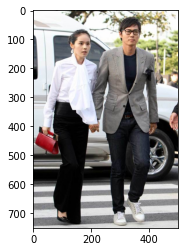

In [2]:
img_paths = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_paths) 


print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()


In [3]:
img_origs = []

for path in img_paths : 
    img_origs.append(cv2.imread(img_paths))

img_origs[0].shape

(750, 500, 3)

### (3) Semantic Segmentation 다루기
- DeepLab이라는 Segmentation 모델을 만들고 모델에 이미지를 입력
- DeepLabModel 클래스

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(750, 500, 3) (513, 342, 3) 15


In [7]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f093818e820>)

In [8]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [9]:
segvalues, output = model.segmentAsPascalvoc(img_paths)

In [10]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

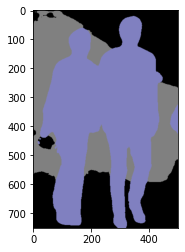

In [11]:
plt.imshow(output)
plt.show()

In [12]:
segvalues

{'class_ids': array([ 0,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [13]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
car
person


In [14]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [15]:
colormap[15]

array([192, 128, 128])

In [16]:
seg_color = (128,128,192)

(750, 500)


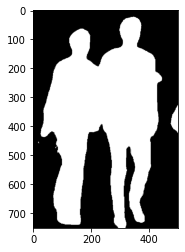

In [17]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

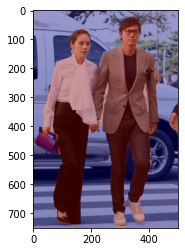

In [18]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


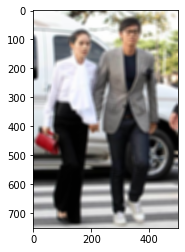

In [19]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

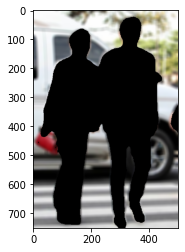

In [20]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


### (4) 문제점 

- img_bg 결과 앞 사람 손까지 같이 분리됨 
- 손에 들고 있는 가방은 분리 되지 않음
- 뒤에 자동차도 분리가 됨 

### (5) 해결책

- 3D Depth 카메라를 활용 : RiDAR 센서, 후면카메라 등을 활용해서 피사체의 심도를 측정 가능케 하면 해결될것으로 보인다 

In [22]:
def segmentation(img_orig, label):
    img_resized, seg_map = MODEL.run(img_orig)
    LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
    
    label_idx = LABEL_NAMES.index(label)
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label_idx, label_idx, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    plt.figure(figsize=(15, 30))
    plt.subplot(1,2,1)
    plt.title('segmentation img')
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
#     plt.show()
    

    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    
    img_bg_blur = cv2.blur(img_bg, (40, 40))  # 원래는 (13, 13), 이미지의 사이즈가 워낙 커서 값을 늘림
    
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    plt.subplot(1,2,2)
    plt.title('blurred img')
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    

### (6) 배경전환 크로마키 사진 만들기 

- 새끼고양이 사진과 그 사진에 어울리는 손 사진을 합쳐보기로 한다 
- 배경의 사이즈도 resize를 해주기 위해서 새끼고양이 사진 사이즈를 저장해둔다.

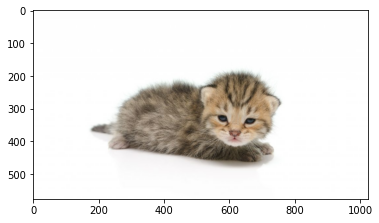

(576, 1024, 3)


In [23]:
kitten = os.getenv('HOME')+'/aiffel/human_segmentation/images/kitten.png'  
img_orig = cv2.imread(kitten) 

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

h, w,_ = img_orig.shape
print(img_orig.shape)


- 배경마스크, content마스크, 그리고 content를 리턴해주는 함수를 작성한다
- 입력인자는 이미지의 경로

In [24]:
def ret_mask(kitten) :
    # 이미지 읽기
    img_gbr = cv2.imread(kitten)
    img_resized, seg_map = MODEL.run(img_gbr)
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == seg_map.max(), seg_map.max(), 0)
    img_mask = seg_map * (255/seg_map.max())
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
#    img_show = cv2.addWeighted(img_show, 0.6)
    
    img_mask_up = cv2.resize(img_mask, img_gbr.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    
    
    img_content_mask = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    
    content = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    
    
    return img_bg_mask, img_mask_color, content

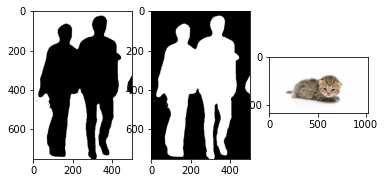

In [25]:
kitten_bg_mask, kitten_content_mask, kitten_content = ret_mask(os.getenv('HOME')+'/aiffel/human_segmentation/images/kitten.png')
plt.subplot(1,3,1)
plt.imshow(kitten_bg_mask)

plt.subplot(1,3,2)
plt.imshow(kitten_content_mask)

plt.subplot(1,3,3)
plt.imshow(kitten_content)

plt.show()

### (7) 배경사진 불러내기

(235, 428, 3)


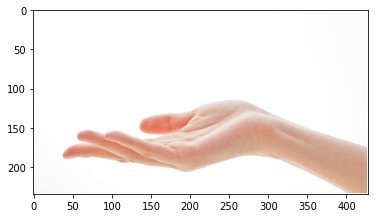

In [26]:
back1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/palm.png'  
palm = cv2.imread(back1) 

print(palm.shape)
plt.imshow(cv2.cvtColor(palm, cv2.COLOR_BGR2RGB))
plt.show()


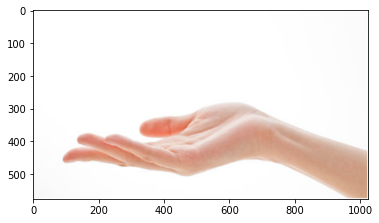

In [27]:
palm = cv2.resize(palm, (w, h))
plt.imshow(cv2.cvtColor(palm, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
np.unique(kitten_content_mask)

array([  0, 255], dtype=uint8)

In [ ]:
result1 = cv2.bitwise_and(palm, kitten_content_mask)
result1 = np.where(result1 == kitten_content_mask, palm, kitten_content)
plt.imshow(result1)
plt.show()

# 회고 

- 커넬이 계속 죽어서 진행에 어려움이 있었다. 
- 세그멘테이션으로 사람 분리하기, 시맨틱 세그멘테이션 으로 피사체와 배경을 분리하기,  배경 흐리게 하기, 인물모드 문제점 찾기는 진행할 수 있었고 나름 재미있었는데 합성은 하지 못해 아쉽다. 
- 손 위에 아기고양이를 얹으려고 한 것 인데, 두 이미지의 사이즈가 맞아야 가능한 연산이라 합성하고 싶은 부분을 특정해서 뽑아낸 후 이미지를 합쳐 볼 수 있을것으로 예상한다. 제출은 이대로 하겠지만 앞으로 더 배워나가면서 제대로 합성도 해 보고 다른 사진들로도 연습을 많이 해보고 싶다. 
